# Group Recommender Systems - Tutorial 2 (Lab 2)


In this tutorial, we will see implement a pipeline for offline evaluation of Group Recommender Systems. After completing this tutorial, you will be able to: 
- Create synthetic groups with different sizes and internal similarities.
- Implement basic strategies for aggregating group members' predicted ratings and provide group recommendations.
- Evaluate the performance of the group recommender systems, using different a coupled or a decoupled evaluation protocol.


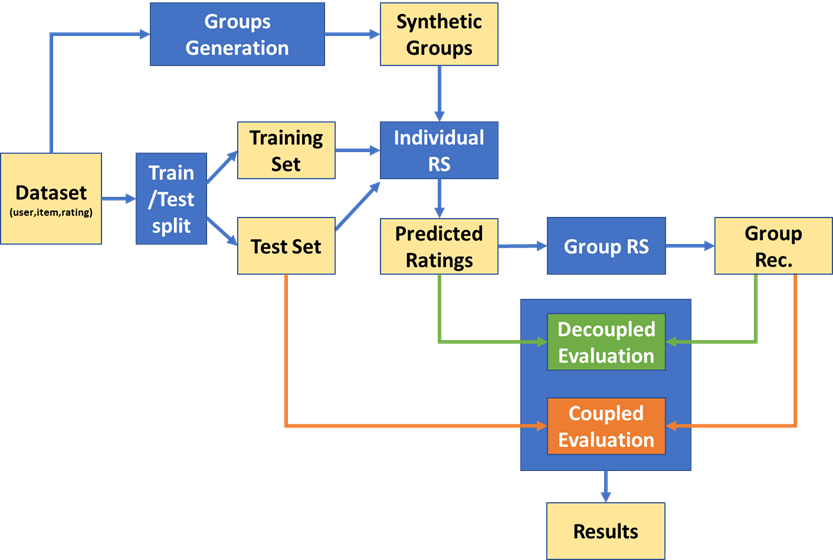

We start using the [pandas](https://pandas.pydata.org/) library to read the content of the CSV files and use it, as we did in the Lab 1.


In [1]:
import pandas as pd


In [2]:
ratings_df = pd.read_csv("XWines_Slim_150K_ratings.csv") 


C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_9060\2794468238.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings_df = pd.read_csv("XWines_Slim_150K_ratings.csv")


In [3]:
ratings_df = ratings_df.drop(columns=['Vintage', 'Date'])


In [4]:
wine_df = pd.read_csv('XWines_Slim_1K_wines.csv', index_col="WineID")


#### 2. Preprocessing


To generate synthetic groups we need to be able to evaluate similarities between users. As we only have the information about ratings, we will use this. Hence, we want to focus on users for which we can compute this similarity, requiring a minimum amount of rated WineIDs (and discarding the remaining users). At the same time, we want to focus on WineIDs rated by a certain number of users. In this pre-processing step, we will filter out users and WineIDs not having enough ratings. 

In [5]:
# Check number of ratings per WineID
rating_per_WineID_df = ratings_df.groupby(['WineID']).count().sort_values(by="Rating", ascending=False)


# Check number of ratings per user
rating_per_user_df = ratings_df.groupby(['UserID']).count().sort_values(by="Rating", ascending=False)


In [6]:
min_ratings_per_WineID = 10
min_ratings_per_user = 10

#this is wrong
#min_ratings_per_WineID = 10
#min_ratings_per_user = 10

In [7]:
# select WineIDs with the desidered number of ratings
selected_WineIDs = list(rating_per_WineID_df.loc[rating_per_WineID_df['Rating'] >= min_ratings_per_WineID].reset_index()['WineID'])

selected_ratings_df = ratings_df.loc[ratings_df['WineID'].isin(selected_WineIDs)]


# Check number of ratings per WineID
rating_per_WineID_df = selected_ratings_df.groupby(['WineID']).count().sort_values(by="Rating", ascending=False)


# Check number of ratings per user
rating_per_user_df = selected_ratings_df.groupby(['UserID']).count().sort_values(by="Rating", ascending=False)


# THis is the right code to make it work

In [8]:
# select users with the desidered number of ratings
selected_users = list(rating_per_user_df.loc[rating_per_user_df['Rating'] >= min_ratings_per_user].reset_index()['UserID'])

selected_ratings_df = selected_ratings_df.loc[ratings_df['UserID'].isin(selected_users)]


# Check number of ratings per WineID
rating_per_WineID_df = selected_ratings_df.groupby(['WineID']).count().sort_values(by="Rating", ascending=False)


# Check number of ratings per user
rating_per_user_df = selected_ratings_df.groupby(['UserID']).count().sort_values(by="Rating", ascending=False)


#### 3. Synthetic groups generation



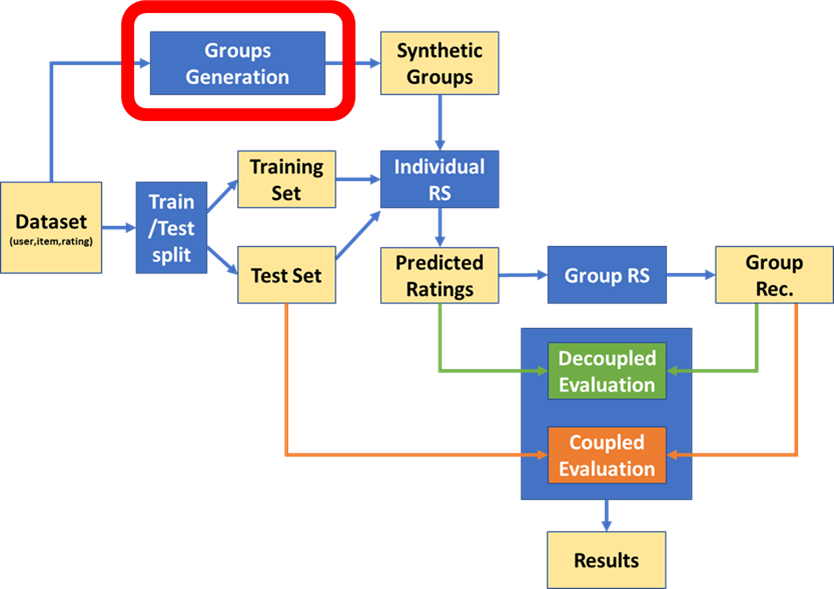


- Which types of groups will we generate? 
- Which sizes we want to evaluate?
- Similarity metric?
- How many groups?

We need to generate groups using the users from the dataset. As we don't have any information for this, we can only use the provided ratings. Two reasonable criteria to use in this case are:
1. Size: we can generate groups of different sizes and compare the performances of our strategies for different group sizes.
2. Similarity: we can generate easier and more difficult groups considering the internal similarity of the preferences.


#### 3.1 Similarity metric

In this example, we use the pearson correlation. This is often used in these types of evaluations. We assume two users are similar if their "rating patterns" are similar. This may not have sense in all cases, and the choice of the similarity metric needs to be motivated for the specific dataset.

In [9]:
# computing pearson similarity between each pair of users

import numpy as np

ratings_df = selected_ratings_df

user_matrix = ratings_df.pivot_table(columns='WineID', index='UserID', values='Rating')

user_id_set = set(ratings_df['UserID'])
user_id_indexes = user_matrix.index.values

user_matrix = user_matrix.fillna(0)
numpy_array = user_matrix.to_numpy()
sim_matrix = np.corrcoef(numpy_array)


Text(0.5, 0, "Pearson's Correlation Coeficient")

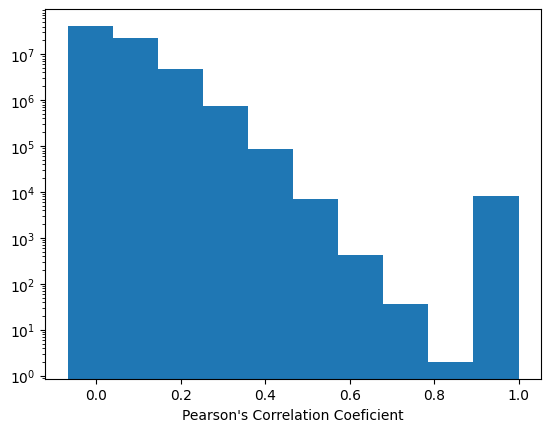

In [10]:
# visualizing similarity distributions

%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(sim_matrix.flatten())
plt.yscale("log")
plt.xlabel("Pearson's Correlation Coeficient")

#### 3.2 Group Generation

We focus here on types of groups defined on the basis of the internal similarity between the group member's preferences. The code below generates:
- types: similar, random, divergent
- sizes: 2 to 8 members per group
- number of group: 20 for each type and size combination

In [11]:
from importlib import reload

import aggregators as groups_gen_utils
reload(groups_gen_utils)
import groups_generators as groups_gen_utils

#group_sizes_to_create = [2,4,8] 
group_sizes_to_create = [2, 3, 4, 5, 6, 7, 8]
group_similarity_to_create = [groups_gen_utils.GroupsGenerator.RANDOM,groups_gen_utils.GroupsGenerator.SIMILAR]
group_number = 20

group_list = list()
for group_to_create in group_similarity_to_create:
    grpGenerator = groups_gen_utils.GroupsGenerator.getGroupsGenerator(group_to_create)
    current_group_list = grpGenerator.generateGroups(user_id_indexes, user_id_set, sim_matrix, group_sizes_to_create, group_number)
    group_list = group_list + current_group_list

groups_df = pd.DataFrame.from_records(group_list)
group_dict = dict()
for group_id, group in zip(range(len(group_list)), group_list):
    group_dict[group_id] = group
    display(group_dict[group_id])



20
40
60
80
100
120
140
20
40
60
80
100
120
140


{'group_size': 2,
 'group_similarity': 'random',
 'group_members': [1181273, 1210044],
 'avg_similarity': -0.015017025527324014}

{'group_size': 2,
 'group_similarity': 'random',
 'group_members': [1163644, 1062705],
 'avg_similarity': -0.013512239109510566}

{'group_size': 2,
 'group_similarity': 'random',
 'group_members': [1183974, 1204114],
 'avg_similarity': 0.06700855647038578}

{'group_size': 2,
 'group_similarity': 'random',
 'group_members': [1375234, 1281220],
 'avg_similarity': 0.24102651579352094}

{'group_size': 2,
 'group_similarity': 'random',
 'group_members': [1050287, 1107737],
 'avg_similarity': 0.10364619734998799}

{'group_size': 2,
 'group_similarity': 'random',
 'group_members': [1000413, 1054892],
 'avg_similarity': 0.035894811263418105}

{'group_size': 2,
 'group_similarity': 'random',
 'group_members': [1001903, 1838645],
 'avg_similarity': 0.09153893981424217}

{'group_size': 2,
 'group_similarity': 'random',
 'group_members': [1079580, 1208255],
 'avg_similarity': -0.016953791531084658}

{'group_size': 2,
 'group_similarity': 'random',
 'group_members': [1011307, 1149221],
 'avg_similarity': -0.016444068538808403}

{'group_size': 2,
 'group_similarity': 'random',
 'group_members': [1222892, 1996565],
 'avg_similarity': -0.017857640214290833}

{'group_size': 2,
 'group_similarity': 'random',
 'group_members': [1317338, 1216998],
 'avg_similarity': -0.015815542936537287}

{'group_size': 2,
 'group_similarity': 'random',
 'group_members': [1467023, 1181902],
 'avg_similarity': -0.024129261240035532}

{'group_size': 2,
 'group_similarity': 'random',
 'group_members': [1740628, 1648535],
 'avg_similarity': -0.01950882868552924}

{'group_size': 2,
 'group_similarity': 'random',
 'group_members': [1920071, 1009552],
 'avg_similarity': -0.013006335022318415}

{'group_size': 2,
 'group_similarity': 'random',
 'group_members': [1007217, 1241925],
 'avg_similarity': -0.02574190078286631}

{'group_size': 2,
 'group_similarity': 'random',
 'group_members': [1624113, 1198370],
 'avg_similarity': -0.015606607561252473}

{'group_size': 2,
 'group_similarity': 'random',
 'group_members': [1218419, 1126241],
 'avg_similarity': 0.06887696083185793}

{'group_size': 2,
 'group_similarity': 'random',
 'group_members': [1212005, 1104980],
 'avg_similarity': 0.042256292420784186}

{'group_size': 2,
 'group_similarity': 'random',
 'group_members': [1119625, 1150720],
 'avg_similarity': 0.020386766375078164}

{'group_size': 2,
 'group_similarity': 'random',
 'group_members': [1355628, 1073615],
 'avg_similarity': -0.015894322922549754}

{'group_size': 3,
 'group_similarity': 'random',
 'group_members': [1175414, 1209281, 1072205],
 'avg_similarity': 0.05338710938324374}

{'group_size': 3,
 'group_similarity': 'random',
 'group_members': [1227382, 1295372, 1586433],
 'avg_similarity': 0.013722961524811506}

{'group_size': 3,
 'group_similarity': 'random',
 'group_members': [1198868, 1259685, 1220928],
 'avg_similarity': 0.027280848444543333}

{'group_size': 3,
 'group_similarity': 'random',
 'group_members': [1823440, 1205171, 1223698],
 'avg_similarity': 0.048715248751081186}

{'group_size': 3,
 'group_similarity': 'random',
 'group_members': [1230268, 1211242, 1234499],
 'avg_similarity': 0.16214537560577405}

{'group_size': 3,
 'group_similarity': 'random',
 'group_members': [1060819, 1199420, 1252540],
 'avg_similarity': 0.0056260552345865494}

{'group_size': 3,
 'group_similarity': 'random',
 'group_members': [1175433, 1251633, 1175691],
 'avg_similarity': -0.01683505027687499}

{'group_size': 3,
 'group_similarity': 'random',
 'group_members': [1097430, 1241471, 1278806],
 'avg_similarity': 0.027137730063105974}

{'group_size': 3,
 'group_similarity': 'random',
 'group_members': [1227649, 1198287, 1198962],
 'avg_similarity': 0.15058634220046752}

{'group_size': 3,
 'group_similarity': 'random',
 'group_members': [1067720, 1365762, 1647874],
 'avg_similarity': 0.0026326513359417746}

{'group_size': 3,
 'group_similarity': 'random',
 'group_members': [1132460, 1210773, 1041030],
 'avg_similarity': 0.02114082077266143}

{'group_size': 3,
 'group_similarity': 'random',
 'group_members': [1075760, 1912533, 1295372],
 'avg_similarity': 0.08038257170332419}

{'group_size': 3,
 'group_similarity': 'random',
 'group_members': [1180721, 1287381, 1021220],
 'avg_similarity': 0.05403473798580726}

{'group_size': 3,
 'group_similarity': 'random',
 'group_members': [1284830, 1224439, 1937384],
 'avg_similarity': 0.00970275576821387}

{'group_size': 3,
 'group_similarity': 'random',
 'group_members': [1006903, 1186489, 1363727],
 'avg_similarity': 0.05955784923098256}

{'group_size': 3,
 'group_similarity': 'random',
 'group_members': [1007221, 1133192, 1181839],
 'avg_similarity': 0.01618290757338377}

{'group_size': 3,
 'group_similarity': 'random',
 'group_members': [1199261, 1713364, 1243525],
 'avg_similarity': 0.011746925750421902}

{'group_size': 3,
 'group_similarity': 'random',
 'group_members': [2033533, 1148875, 1234242],
 'avg_similarity': 0.1260783423050121}

{'group_size': 3,
 'group_similarity': 'random',
 'group_members': [1205159, 1075709, 1000280],
 'avg_similarity': 0.07858670816531714}

{'group_size': 3,
 'group_similarity': 'random',
 'group_members': [1206247, 1412854, 1277360],
 'avg_similarity': -0.013411831522940636}

{'group_size': 4,
 'group_similarity': 'random',
 'group_members': [1253019, 1212447, 1004135, 1012585],
 'avg_similarity': 0.06340473954283098}

{'group_size': 4,
 'group_similarity': 'random',
 'group_members': [1094253, 1151378, 1026681, 1195521],
 'avg_similarity': -0.0030385309285077574}

{'group_size': 4,
 'group_similarity': 'random',
 'group_members': [1181209, 1164179, 1118337, 1214762],
 'avg_similarity': 0.014772272301534455}

{'group_size': 4,
 'group_similarity': 'random',
 'group_members': [1355542, 1571039, 1166991, 1216998],
 'avg_similarity': 0.06252126817077751}

{'group_size': 4,
 'group_similarity': 'random',
 'group_members': [1260145, 1049319, 1177993, 1397265],
 'avg_similarity': 0.06528999098039781}

{'group_size': 4,
 'group_similarity': 'random',
 'group_members': [1143905, 1856266, 1054228, 1275162],
 'avg_similarity': 0.035340507836185454}

{'group_size': 4,
 'group_similarity': 'random',
 'group_members': [1061004, 1593728, 1012688, 1404497],
 'avg_similarity': 0.03351601594064438}

{'group_size': 4,
 'group_similarity': 'random',
 'group_members': [1225542, 1262373, 1221529, 1219477],
 'avg_similarity': 0.019147150069547963}

{'group_size': 4,
 'group_similarity': 'random',
 'group_members': [1010761, 1403681, 1272667, 1085204],
 'avg_similarity': 0.06436564846599943}

{'group_size': 4,
 'group_similarity': 'random',
 'group_members': [1259599, 1359137, 1290274, 1104028],
 'avg_similarity': 0.023954377273592623}

{'group_size': 4,
 'group_similarity': 'random',
 'group_members': [1009773, 1118470, 1230483, 1074177],
 'avg_similarity': 0.11691969620514932}

{'group_size': 4,
 'group_similarity': 'random',
 'group_members': [1126261, 1123182, 1231013, 1199134],
 'avg_similarity': 0.030759383060592175}

{'group_size': 4,
 'group_similarity': 'random',
 'group_members': [1404242, 2033379, 1219019, 1027434],
 'avg_similarity': -0.005936548437520614}

{'group_size': 4,
 'group_similarity': 'random',
 'group_members': [1166935, 1195126, 1220913, 1007636],
 'avg_similarity': 0.06117732275639384}

{'group_size': 4,
 'group_similarity': 'random',
 'group_members': [1355604, 1084787, 1048325, 1066500],
 'avg_similarity': 0.03839315380175035}

{'group_size': 4,
 'group_similarity': 'random',
 'group_members': [1153058, 1189866, 1773459, 1116686],
 'avg_similarity': 0.03026076342898715}

{'group_size': 4,
 'group_similarity': 'random',
 'group_members': [1367409, 1204015, 1400043, 1141906],
 'avg_similarity': 0.0033524455522386926}

{'group_size': 4,
 'group_similarity': 'random',
 'group_members': [1204997, 1220649, 1138648, 1097812],
 'avg_similarity': 0.005074272596561183}

{'group_size': 4,
 'group_similarity': 'random',
 'group_members': [1072218, 1185372, 1001923, 1970500],
 'avg_similarity': 0.0159477853835804}

{'group_size': 4,
 'group_similarity': 'random',
 'group_members': [1666308, 1123304, 1035905, 1021862],
 'avg_similarity': 0.05440822981579673}

{'group_size': 5,
 'group_similarity': 'random',
 'group_members': [1676225, 1219399, 1000027, 1026680, 1123443],
 'avg_similarity': 0.020889759654581518}

{'group_size': 5,
 'group_similarity': 'random',
 'group_members': [1894453, 1002048, 1218633, 1774211, 1055666],
 'avg_similarity': -0.018896144422967665}

{'group_size': 5,
 'group_similarity': 'random',
 'group_members': [1098036, 1064762, 1683935, 1094090, 1084541],
 'avg_similarity': -0.0031232081620909896}

{'group_size': 5,
 'group_similarity': 'random',
 'group_members': [1986488, 1194743, 1593728, 1270119, 1120813],
 'avg_similarity': 0.03572915159935889}

{'group_size': 5,
 'group_similarity': 'random',
 'group_members': [1251943, 1154286, 1224295, 1175256, 1394099],
 'avg_similarity': 0.026467977908187494}

{'group_size': 5,
 'group_similarity': 'random',
 'group_members': [1011730, 1986488, 1269107, 1195964, 1194931],
 'avg_similarity': 0.033237289459445374}

{'group_size': 5,
 'group_similarity': 'random',
 'group_members': [1182409, 1001984, 2038461, 1151267, 1219320],
 'avg_similarity': 0.03506111492332134}

{'group_size': 5,
 'group_similarity': 'random',
 'group_members': [1225234, 1016856, 1251995, 1090238, 1395679],
 'avg_similarity': 0.054407824449494234}

{'group_size': 5,
 'group_similarity': 'random',
 'group_members': [1116050, 1238419, 1226136, 1002934, 1036201],
 'avg_similarity': 0.022846260485859936}

{'group_size': 5,
 'group_similarity': 'random',
 'group_members': [1157481, 1109518, 1397463, 1603377, 1100656],
 'avg_similarity': 0.014419938251054944}

{'group_size': 5,
 'group_similarity': 'random',
 'group_members': [1448690, 1220700, 1651965, 1218812, 1215616],
 'avg_similarity': 3.336820738114206e-05}

{'group_size': 5,
 'group_similarity': 'random',
 'group_members': [1241059, 1360735, 1181914, 1206650, 1027465],
 'avg_similarity': 0.011962208647488991}

{'group_size': 5,
 'group_similarity': 'random',
 'group_members': [1102911, 1287609, 1166102, 1110161, 1243210],
 'avg_similarity': 0.03411704066843669}

{'group_size': 5,
 'group_similarity': 'random',
 'group_members': [1144404, 1048431, 1074045, 1055020, 1194274],
 'avg_similarity': 0.03146161384713219}

{'group_size': 5,
 'group_similarity': 'random',
 'group_members': [1183295, 1182198, 1141906, 1003800, 1079318],
 'avg_similarity': 0.04261916383718789}

{'group_size': 5,
 'group_similarity': 'random',
 'group_members': [1284001, 1081343, 1184845, 1225096, 1288693],
 'avg_similarity': 0.01283942248882447}

{'group_size': 5,
 'group_similarity': 'random',
 'group_members': [1008430, 1166995, 1399842, 1567934, 1249873],
 'avg_similarity': 0.01503996100582031}

{'group_size': 5,
 'group_similarity': 'random',
 'group_members': [1249386, 1186443, 1019236, 1182886, 1258642],
 'avg_similarity': 0.07755810726961458}

{'group_size': 5,
 'group_similarity': 'random',
 'group_members': [1275731, 1059340, 1001050, 1039770, 1234496],
 'avg_similarity': 0.10122467933768249}

{'group_size': 5,
 'group_similarity': 'random',
 'group_members': [1214899, 1220771, 1358040, 1189761, 1145071],
 'avg_similarity': 0.050285089443952324}

{'group_size': 6,
 'group_similarity': 'random',
 'group_members': [1134462, 1132037, 1269163, 1117850, 1318416, 1588076],
 'avg_similarity': 0.012008503621914274}

{'group_size': 6,
 'group_similarity': 'random',
 'group_members': [1560869, 1019809, 1130721, 1175982, 1048395, 1210627],
 'avg_similarity': 0.06692020930441853}

{'group_size': 6,
 'group_similarity': 'random',
 'group_members': [1821735, 1052761, 1121081, 1064752, 1269346, 1218131],
 'avg_similarity': 0.025277250682913366}

{'group_size': 6,
 'group_similarity': 'random',
 'group_members': [1224087, 1208541, 1404693, 1199420, 1363311, 1256931],
 'avg_similarity': 0.03607702249024867}

{'group_size': 6,
 'group_similarity': 'random',
 'group_members': [1195521, 1186326, 1099558, 1233479, 1077974, 1227820],
 'avg_similarity': 0.02186616530307849}

{'group_size': 6,
 'group_similarity': 'random',
 'group_members': [1248627, 1152054, 1086238, 1210574, 1406678, 1240552],
 'avg_similarity': 0.02224787653368786}

{'group_size': 6,
 'group_similarity': 'random',
 'group_members': [1037217, 1043492, 1378235, 1205123, 1225874, 1262373],
 'avg_similarity': 0.0494286607460073}

{'group_size': 6,
 'group_similarity': 'random',
 'group_members': [1359651, 1152172, 1254506, 1519799, 1227953, 1122925],
 'avg_similarity': 0.05794973143856836}

{'group_size': 6,
 'group_similarity': 'random',
 'group_members': [1055502, 1677613, 1041366, 1037428, 1097452, 1060068],
 'avg_similarity': 0.019023344210768883}

{'group_size': 6,
 'group_similarity': 'random',
 'group_members': [1558407, 1223121, 1003642, 1122981, 1099446, 1049089],
 'avg_similarity': 0.05203266174828658}

{'group_size': 6,
 'group_similarity': 'random',
 'group_members': [1578909, 1397216, 1035503, 1361053, 1112645, 1073615],
 'avg_similarity': 0.010949327757944534}

{'group_size': 6,
 'group_similarity': 'random',
 'group_members': [1262028, 1664020, 1055837, 1397409, 1020500, 1164984],
 'avg_similarity': 0.024243396991939902}

{'group_size': 6,
 'group_similarity': 'random',
 'group_members': [1186101, 1204663, 1332470, 1456712, 1982845, 1183082],
 'avg_similarity': 0.008969032952168377}

{'group_size': 6,
 'group_similarity': 'random',
 'group_members': [1003845, 1222522, 1202864, 1240725, 1003716, 1248356],
 'avg_similarity': 0.029392064411688613}

{'group_size': 6,
 'group_similarity': 'random',
 'group_members': [1103077, 1541151, 1145025, 1103774, 1001876, 1927567],
 'avg_similarity': 0.07523951866049629}

{'group_size': 6,
 'group_similarity': 'random',
 'group_members': [1356789, 1201359, 1438993, 1196484, 1127111, 1239676],
 'avg_similarity': 0.024277461735239033}

{'group_size': 6,
 'group_similarity': 'random',
 'group_members': [1200999, 1002920, 1022614, 1463259, 1097527, 1367304],
 'avg_similarity': 0.032541202589064115}

{'group_size': 6,
 'group_similarity': 'random',
 'group_members': [1647874, 1019602, 1010338, 1358890, 1282029, 1364737],
 'avg_similarity': 0.042291767282075704}

{'group_size': 6,
 'group_similarity': 'random',
 'group_members': [1007559, 1310216, 1221366, 1235289, 1121653, 1621968],
 'avg_similarity': 0.03248963812066555}

{'group_size': 6,
 'group_similarity': 'random',
 'group_members': [1437775, 1028699, 1271664, 1103648, 1276338, 1126124],
 'avg_similarity': 0.026849852893515904}

{'group_size': 7,
 'group_similarity': 'random',
 'group_members': [1150720,
  1221460,
  1147610,
  1619963,
  1241324,
  1221999,
  1145738],
 'avg_similarity': 0.03646876577476823}

{'group_size': 7,
 'group_similarity': 'random',
 'group_members': [1070852,
  1153860,
  1228593,
  1391592,
  1106008,
  1136184,
  1230289],
 'avg_similarity': 0.03536459145335256}

{'group_size': 7,
 'group_similarity': 'random',
 'group_members': [1126072,
  1003694,
  1280715,
  1676225,
  1490391,
  1249521,
  1144417],
 'avg_similarity': 0.025385647272998017}

{'group_size': 7,
 'group_similarity': 'random',
 'group_members': [1175039,
  1104259,
  1174089,
  1249525,
  1095090,
  1001872,
  1252960],
 'avg_similarity': 0.002609707525715696}

{'group_size': 7,
 'group_similarity': 'random',
 'group_members': [1793507,
  1553959,
  1034621,
  1076000,
  1105820,
  1580712,
  1135434],
 'avg_similarity': 0.027908299962875655}

{'group_size': 7,
 'group_similarity': 'random',
 'group_members': [1194377,
  1019602,
  1041755,
  1004315,
  1219363,
  1118509,
  1221687],
 'avg_similarity': 0.034088184107959}

{'group_size': 7,
 'group_similarity': 'random',
 'group_members': [1694016,
  1100049,
  1286729,
  1195157,
  1361646,
  1129529,
  1222015],
 'avg_similarity': 0.08842712050294661}

{'group_size': 7,
 'group_similarity': 'random',
 'group_members': [1123122,
  1207410,
  1146965,
  1009488,
  1282001,
  1045552,
  1176070],
 'avg_similarity': 0.04551822051683602}

{'group_size': 7,
 'group_similarity': 'random',
 'group_members': [1571449,
  1224566,
  1829264,
  1405701,
  1220771,
  1780974,
  1144417],
 'avg_similarity': 0.0392386191167695}

{'group_size': 7,
 'group_similarity': 'random',
 'group_members': [1083783,
  1184472,
  1078368,
  1763441,
  1140932,
  1132313,
  1034718],
 'avg_similarity': 0.031105946510553678}

{'group_size': 7,
 'group_similarity': 'random',
 'group_members': [1189753,
  1202289,
  1076000,
  1683806,
  1165429,
  1218823,
  1670966],
 'avg_similarity': 0.05651460015490043}

{'group_size': 7,
 'group_similarity': 'random',
 'group_members': [1059272,
  1187858,
  1036201,
  1034818,
  1098036,
  1139703,
  1191140],
 'avg_similarity': 0.039433111083165294}

{'group_size': 7,
 'group_similarity': 'random',
 'group_members': [1217046,
  1207627,
  1905155,
  1061452,
  1948341,
  1312816,
  1066078],
 'avg_similarity': 0.013367229632446026}

{'group_size': 7,
 'group_similarity': 'random',
 'group_members': [1100262,
  1873188,
  1360632,
  1019696,
  1007570,
  1036683,
  1203482],
 'avg_similarity': 0.018865492444999882}

{'group_size': 7,
 'group_similarity': 'random',
 'group_members': [1645580,
  1587773,
  1124387,
  1366118,
  1197321,
  1123174,
  1269640],
 'avg_similarity': 0.005745228590164523}

{'group_size': 7,
 'group_similarity': 'random',
 'group_members': [1039935,
  1083473,
  1035982,
  1277541,
  1128097,
  1226918,
  1027465],
 'avg_similarity': 0.045068336835535905}

{'group_size': 7,
 'group_similarity': 'random',
 'group_members': [1191518,
  1807227,
  1276863,
  1248506,
  1147504,
  1152108,
  1437775],
 'avg_similarity': 0.007775124849216121}

{'group_size': 7,
 'group_similarity': 'random',
 'group_members': [1211238,
  1126323,
  1153158,
  1234112,
  1224634,
  1214006,
  1189309],
 'avg_similarity': 0.06384713430494589}

{'group_size': 7,
 'group_similarity': 'random',
 'group_members': [1194459,
  1211031,
  1176344,
  1129756,
  1191303,
  1041139,
  1070826],
 'avg_similarity': 0.04940386400445605}

{'group_size': 7,
 'group_similarity': 'random',
 'group_members': [1359933,
  1222683,
  1075815,
  1185269,
  1155655,
  1218151,
  1234772],
 'avg_similarity': 0.03282350937940154}

{'group_size': 8,
 'group_similarity': 'random',
 'group_members': [1086921,
  1207700,
  1148091,
  1167307,
  1269517,
  1177861,
  1357095,
  1227544],
 'avg_similarity': 0.03185016805918494}

{'group_size': 8,
 'group_similarity': 'random',
 'group_members': [1055502,
  1185372,
  1096341,
  1254894,
  1223637,
  1006666,
  1408604,
  1284386],
 'avg_similarity': 0.03070714796863721}

{'group_size': 8,
 'group_similarity': 'random',
 'group_members': [1212738,
  1008384,
  1270119,
  1943637,
  1022794,
  1392949,
  1167057,
  1397090],
 'avg_similarity': 0.04937279862932274}

{'group_size': 8,
 'group_similarity': 'random',
 'group_members': [1042506,
  1178383,
  1064787,
  1356170,
  1271225,
  1072392,
  1199134,
  1722794],
 'avg_similarity': 0.01844877957421361}

{'group_size': 8,
 'group_similarity': 'random',
 'group_members': [1210675,
  1175039,
  1384485,
  1359898,
  1010029,
  1127342,
  1219491,
  1283871],
 'avg_similarity': 0.04951643618539065}

{'group_size': 8,
 'group_similarity': 'random',
 'group_members': [2045617,
  1211352,
  1215059,
  1228599,
  1271650,
  1105373,
  1218081,
  1205159],
 'avg_similarity': 0.026474179090073633}

{'group_size': 8,
 'group_similarity': 'random',
 'group_members': [1230135,
  1157237,
  1000754,
  1134191,
  1105524,
  1086238,
  1134573,
  1191823],
 'avg_similarity': 0.016500691258091275}

{'group_size': 8,
 'group_similarity': 'random',
 'group_members': [1255376,
  1056169,
  1271899,
  1263632,
  1411687,
  1165465,
  1629686,
  1703926],
 'avg_similarity': 0.060871413674321424}

{'group_size': 8,
 'group_similarity': 'random',
 'group_members': [1075859,
  1184787,
  1214650,
  1791631,
  1438993,
  1357819,
  1167057,
  1011441],
 'avg_similarity': 0.05290342290769406}

{'group_size': 8,
 'group_similarity': 'random',
 'group_members': [1222847,
  1046175,
  1184661,
  1404675,
  1223036,
  1220928,
  1226341,
  1269304],
 'avg_similarity': 0.03671041817232347}

{'group_size': 8,
 'group_similarity': 'random',
 'group_members': [1054892,
  1140932,
  1195527,
  1038502,
  1182115,
  1181622,
  1065940,
  1100812],
 'avg_similarity': 0.04700349118433911}

{'group_size': 8,
 'group_similarity': 'random',
 'group_members': [1070788,
  1230158,
  1231229,
  1162355,
  1037589,
  1186724,
  1000559,
  1355778],
 'avg_similarity': 0.04278750966280383}

{'group_size': 8,
 'group_similarity': 'random',
 'group_members': [1212437,
  1074177,
  1259023,
  1129756,
  1189331,
  1163123,
  1277670,
  1123069],
 'avg_similarity': 0.02271922693902403}

{'group_size': 8,
 'group_similarity': 'random',
 'group_members': [1275105,
  1251932,
  1048810,
  1137610,
  1217738,
  1143566,
  1932067,
  1107398],
 'avg_similarity': 0.04506052134940846}

{'group_size': 8,
 'group_similarity': 'random',
 'group_members': [1177237,
  1019780,
  1126907,
  1213955,
  1009249,
  1689323,
  1385979,
  1248077],
 'avg_similarity': 0.05294312690565211}

{'group_size': 8,
 'group_similarity': 'random',
 'group_members': [1005780,
  1179223,
  1236239,
  1022794,
  2008125,
  1186428,
  1004315,
  1147225],
 'avg_similarity': 0.016074209905469154}

{'group_size': 8,
 'group_similarity': 'random',
 'group_members': [1040098,
  1121026,
  1000197,
  1288809,
  1299127,
  1172861,
  1243264,
  1254325],
 'avg_similarity': 0.0162466402414743}

{'group_size': 8,
 'group_similarity': 'random',
 'group_members': [1193303,
  1710118,
  1131099,
  1935375,
  1266755,
  1126550,
  1173740,
  1191796],
 'avg_similarity': 0.01866868081584399}

{'group_size': 8,
 'group_similarity': 'random',
 'group_members': [1201057,
  1204227,
  1127909,
  1208448,
  1011385,
  1388324,
  1075710,
  1359678],
 'avg_similarity': 0.01228544232575876}

{'group_size': 8,
 'group_similarity': 'random',
 'group_members': [1111797,
  1021833,
  1357053,
  1686996,
  1146995,
  1217272,
  1185187,
  1235752],
 'avg_similarity': 0.021521855316735016}

{'group_size': 2,
 'group_similarity': 'similar',
 'group_members': [1177987, 1194711],
 'avg_similarity': 0.30275153467995786}

{'group_size': 2,
 'group_similarity': 'similar',
 'group_members': [1621968, 1393066],
 'avg_similarity': 0.22478737871111137}

{'group_size': 2,
 'group_similarity': 'similar',
 'group_members': [1205436, 1213069],
 'avg_similarity': 0.23202480180484197}

{'group_size': 2,
 'group_similarity': 'similar',
 'group_members': [1006401, 1843126],
 'avg_similarity': 0.2430482514498375}

{'group_size': 2,
 'group_similarity': 'similar',
 'group_members': [1164274, 1084297],
 'avg_similarity': 0.20075917567123527}

{'group_size': 2,
 'group_similarity': 'similar',
 'group_members': [1191790, 1041325],
 'avg_similarity': 0.24937937224835405}

{'group_size': 2,
 'group_similarity': 'similar',
 'group_members': [1456772, 1195953],
 'avg_similarity': 0.23069190355712926}

{'group_size': 2,
 'group_similarity': 'similar',
 'group_members': [1054812, 1962088],
 'avg_similarity': 0.2227817424658512}

{'group_size': 2,
 'group_similarity': 'similar',
 'group_members': [1223825, 1280202],
 'avg_similarity': 0.20480859699582177}

{'group_size': 2,
 'group_similarity': 'similar',
 'group_members': [1029534, 1181925],
 'avg_similarity': 0.39197087344433923}

{'group_size': 2,
 'group_similarity': 'similar',
 'group_members': [1020023, 1230649],
 'avg_similarity': 0.24872004510942988}

{'group_size': 2,
 'group_similarity': 'similar',
 'group_members': [1212625, 1206737],
 'avg_similarity': 0.23186117059739553}

{'group_size': 2,
 'group_similarity': 'similar',
 'group_members': [1408615, 1103929],
 'avg_similarity': 0.2788365419987887}

{'group_size': 2,
 'group_similarity': 'similar',
 'group_members': [1359570, 1172654],
 'avg_similarity': 0.25330344320060144}

{'group_size': 2,
 'group_similarity': 'similar',
 'group_members': [1367311, 1006096],
 'avg_similarity': 0.30274226669121806}

{'group_size': 2,
 'group_similarity': 'similar',
 'group_members': [1206982, 1009268],
 'avg_similarity': 0.3671467923485389}

{'group_size': 2,
 'group_similarity': 'similar',
 'group_members': [1948099, 1175938],
 'avg_similarity': 0.3596843454711666}

{'group_size': 2,
 'group_similarity': 'similar',
 'group_members': [1665540, 1843162],
 'avg_similarity': 0.33955875762012366}

{'group_size': 2,
 'group_similarity': 'similar',
 'group_members': [1150300, 1111009],
 'avg_similarity': 0.22781975494669}

{'group_size': 2,
 'group_similarity': 'similar',
 'group_members': [1277685, 1137772],
 'avg_similarity': 0.23173081778619026}

{'group_size': 3,
 'group_similarity': 'similar',
 'group_members': [1038692, 1186227, 1119568],
 'avg_similarity': 0.22595876372890678}

{'group_size': 3,
 'group_similarity': 'similar',
 'group_members': [1255376, 1561132, 1168386],
 'avg_similarity': 0.19986153239406193}

{'group_size': 3,
 'group_similarity': 'similar',
 'group_members': [1099610, 1094562, 1007207],
 'avg_similarity': 0.19879656947917715}

{'group_size': 3,
 'group_similarity': 'similar',
 'group_members': [1267093, 1711002, 1239743],
 'avg_similarity': 0.2117023726630265}

{'group_size': 3,
 'group_similarity': 'similar',
 'group_members': [1218520, 1173623, 1248860],
 'avg_similarity': 0.264131675706968}

{'group_size': 3,
 'group_similarity': 'similar',
 'group_members': [1114690, 1120474, 1042238],
 'avg_similarity': 0.2317125265513054}

{'group_size': 3,
 'group_similarity': 'similar',
 'group_members': [1075824, 1166942, 1395679],
 'avg_similarity': 0.20866054490544228}

{'group_size': 3,
 'group_similarity': 'similar',
 'group_members': [1277030, 1103122, 1124446],
 'avg_similarity': 0.16683311080623808}

{'group_size': 3,
 'group_similarity': 'similar',
 'group_members': [1115688, 1315911, 1181828],
 'avg_similarity': 0.19886581651587196}

{'group_size': 3,
 'group_similarity': 'similar',
 'group_members': [1111257, 1075725, 1281152],
 'avg_similarity': 0.20665014153072417}

{'group_size': 3,
 'group_similarity': 'similar',
 'group_members': [1008509, 1367303, 1230268],
 'avg_similarity': 0.2677590973713078}

{'group_size': 3,
 'group_similarity': 'similar',
 'group_members': [1036320, 1236054, 1203344],
 'avg_similarity': 0.14479048996879162}

{'group_size': 3,
 'group_similarity': 'similar',
 'group_members': [1129670, 1193685, 1215154],
 'avg_similarity': 0.1981760537427323}

{'group_size': 3,
 'group_similarity': 'similar',
 'group_members': [1239752, 1399518, 1230668],
 'avg_similarity': 0.2349404282224827}

{'group_size': 3,
 'group_similarity': 'similar',
 'group_members': [1571685, 1397945, 1930194],
 'avg_similarity': 0.25501438712604546}

{'group_size': 3,
 'group_similarity': 'similar',
 'group_members': [1263883, 1396191, 1214580],
 'avg_similarity': 0.1916066888543082}

{'group_size': 3,
 'group_similarity': 'similar',
 'group_members': [1705690, 1266619, 1277769],
 'avg_similarity': 0.1889168902946319}

{'group_size': 3,
 'group_similarity': 'similar',
 'group_members': [1248263, 1324444, 1234499],
 'avg_similarity': 0.2180619855943655}

{'group_size': 3,
 'group_similarity': 'similar',
 'group_members': [1218314, 1357819, 1062705],
 'avg_similarity': 0.2022633128338516}

{'group_size': 3,
 'group_similarity': 'similar',
 'group_members': [1223348, 1210627, 1395664],
 'avg_similarity': 0.24181125200751916}

{'group_size': 4,
 'group_similarity': 'similar',
 'group_members': [1277108, 1007257, 1811168, 1920981],
 'avg_similarity': 0.18341884917172357}

{'group_size': 4,
 'group_similarity': 'similar',
 'group_members': [1202265, 1053694, 1070827, 1005724],
 'avg_similarity': 0.18862234713799886}

{'group_size': 4,
 'group_similarity': 'similar',
 'group_members': [1185187, 1149986, 1013331, 1135476],
 'avg_similarity': 0.1946330617032458}

{'group_size': 4,
 'group_similarity': 'similar',
 'group_members': [1004019, 1240191, 1203467, 1230290],
 'avg_similarity': 0.20349429572849453}

{'group_size': 4,
 'group_similarity': 'similar',
 'group_members': [1112901, 1389393, 1097099, 1211179],
 'avg_similarity': 0.16760239815965913}

{'group_size': 4,
 'group_similarity': 'similar',
 'group_members': [1255804, 1176746, 1005092, 1012616],
 'avg_similarity': 0.15491414082889066}

{'group_size': 4,
 'group_similarity': 'similar',
 'group_members': [1274444, 1007760, 1254878, 1252855],
 'avg_similarity': 0.19022467103697538}

{'group_size': 4,
 'group_similarity': 'similar',
 'group_members': [1220591, 1173279, 1218742, 1009666],
 'avg_similarity': 0.12333741522415152}

{'group_size': 4,
 'group_similarity': 'similar',
 'group_members': [1979011, 1118337, 1508317, 1223513],
 'avg_similarity': 0.23254659973043693}

{'group_size': 4,
 'group_similarity': 'similar',
 'group_members': [1113310, 1317730, 1007735, 1659666],
 'avg_similarity': 0.1807427590490811}

{'group_size': 4,
 'group_similarity': 'similar',
 'group_members': [1189331, 1210984, 1808077, 1006437],
 'avg_similarity': 0.14661834624272244}

{'group_size': 4,
 'group_similarity': 'similar',
 'group_members': [1264540, 1306186, 1225159, 1397216],
 'avg_similarity': 0.21198562676390523}

{'group_size': 4,
 'group_similarity': 'similar',
 'group_members': [1210446, 1095323, 1026647, 1054846],
 'avg_similarity': 0.23176163911843048}

{'group_size': 4,
 'group_similarity': 'similar',
 'group_members': [1152179, 1219876, 1184514, 1240482],
 'avg_similarity': 0.1187168616555626}

{'group_size': 4,
 'group_similarity': 'similar',
 'group_members': [1151378, 1089025, 1064977, 1109090],
 'avg_similarity': 0.1977596072378743}

{'group_size': 4,
 'group_similarity': 'similar',
 'group_members': [1003951, 1243436, 1075753, 1225590],
 'avg_similarity': 0.1449655851976439}

{'group_size': 4,
 'group_similarity': 'similar',
 'group_members': [1218452, 1215339, 1219320, 1194361],
 'avg_similarity': 0.15862676434045406}

{'group_size': 4,
 'group_similarity': 'similar',
 'group_members': [1008464, 1208172, 1389684, 1134573],
 'avg_similarity': 0.17873319315323977}

{'group_size': 4,
 'group_similarity': 'similar',
 'group_members': [1947450, 1277632, 1151960, 1150869],
 'avg_similarity': 0.18522980308608097}

{'group_size': 4,
 'group_similarity': 'similar',
 'group_members': [1077573, 1226341, 1184424, 1003734],
 'avg_similarity': 0.148377277578419}

{'group_size': 5,
 'group_similarity': 'similar',
 'group_members': [1001019, 1223820, 1193685, 1229696, 1220794],
 'avg_similarity': 0.1379717213573045}

{'group_size': 5,
 'group_similarity': 'similar',
 'group_members': [1209420, 1173690, 1210068, 1886077, 1252744],
 'avg_similarity': 0.18512261770479407}

{'group_size': 5,
 'group_similarity': 'similar',
 'group_members': [1006514, 1078958, 1219372, 1174146, 1009060],
 'avg_similarity': 0.14934044369436733}

{'group_size': 5,
 'group_similarity': 'similar',
 'group_members': [1214825, 1826197, 1215876, 1204227, 1007627],
 'avg_similarity': 0.15618795203206487}

{'group_size': 5,
 'group_similarity': 'similar',
 'group_members': [1006632, 1166464, 1003818, 1222855, 2052014],
 'avg_similarity': 0.11235624039897316}

{'group_size': 5,
 'group_similarity': 'similar',
 'group_members': [1127355, 1174245, 1175001, 1000956, 1189783],
 'avg_similarity': 0.16998825753178332}

{'group_size': 5,
 'group_similarity': 'similar',
 'group_members': [1004867, 1829533, 1159102, 1174733, 1227706],
 'avg_similarity': 0.10012087469102104}

{'group_size': 5,
 'group_similarity': 'similar',
 'group_members': [1151244, 1261660, 1537657, 1254381, 1127180],
 'avg_similarity': 0.16715856953204392}

{'group_size': 5,
 'group_similarity': 'similar',
 'group_members': [1218032, 1186341, 1119705, 1256153, 1255509],
 'avg_similarity': 0.1534034633456031}

{'group_size': 5,
 'group_similarity': 'similar',
 'group_members': [1243721, 1395679, 1697587, 1119608, 1048526],
 'avg_similarity': 0.14455629657939106}

{'group_size': 5,
 'group_similarity': 'similar',
 'group_members': [1363739, 1514023, 1222413, 1002545, 1075757],
 'avg_similarity': 0.19983740288178398}

{'group_size': 5,
 'group_similarity': 'similar',
 'group_members': [1222248, 1356929, 1274392, 1277571, 1003897],
 'avg_similarity': 0.19090316818327677}

{'group_size': 5,
 'group_similarity': 'similar',
 'group_members': [1098400, 1211463, 1000078, 1048305, 1197676],
 'avg_similarity': 0.21484413763043908}

{'group_size': 5,
 'group_similarity': 'similar',
 'group_members': [1163623, 1239867, 1210428, 2056982, 1164164],
 'avg_similarity': 0.21860812253220302}

{'group_size': 5,
 'group_similarity': 'similar',
 'group_members': [1059095, 1221514, 1283597, 1120946, 1280299],
 'avg_similarity': 0.1427167035785301}

{'group_size': 5,
 'group_similarity': 'similar',
 'group_members': [1118733, 2061042, 1213730, 1209403, 1079555],
 'avg_similarity': 0.12221731647419824}

{'group_size': 5,
 'group_similarity': 'similar',
 'group_members': [1255064, 1908805, 1119279, 1264357, 1666548],
 'avg_similarity': 0.10471700782909776}

{'group_size': 5,
 'group_similarity': 'similar',
 'group_members': [1197258, 1393087, 1123761, 1103397, 1076278],
 'avg_similarity': 0.15424217413448693}

{'group_size': 5,
 'group_similarity': 'similar',
 'group_members': [1254294, 1391592, 1230652, 1218578, 1206417],
 'avg_similarity': 0.22430575627357352}

{'group_size': 5,
 'group_similarity': 'similar',
 'group_members': [1021271, 1255366, 1332470, 1026807, 1232244],
 'avg_similarity': 0.14124815101982519}

{'group_size': 6,
 'group_similarity': 'similar',
 'group_members': [1175360, 1218131, 1288893, 1116022, 1195088, 1141671],
 'avg_similarity': 0.1358068231612647}

{'group_size': 6,
 'group_similarity': 'similar',
 'group_members': [1114191, 1229798, 1126391, 1038502, 1201932, 1076528],
 'avg_similarity': 0.1390357181520071}

{'group_size': 6,
 'group_similarity': 'similar',
 'group_members': [1070605, 1195528, 1393775, 1102914, 1215717, 1196224],
 'avg_similarity': 0.14946088925053355}

{'group_size': 6,
 'group_similarity': 'similar',
 'group_members': [1258393, 1240043, 1217632, 1063367, 1360713, 1187016],
 'avg_similarity': 0.17096189472731932}

{'group_size': 6,
 'group_similarity': 'similar',
 'group_members': [1170202, 1222855, 1640263, 1393173, 1787844, 1218447],
 'avg_similarity': 0.15509223871737596}

{'group_size': 6,
 'group_similarity': 'similar',
 'group_members': [1281588, 1291524, 1217541, 1387263, 1154058, 1139395],
 'avg_similarity': 0.096186288053592}

{'group_size': 6,
 'group_similarity': 'similar',
 'group_members': [1008384, 1170122, 1364713, 1213281, 1119974, 1735525],
 'avg_similarity': 0.11840165470922517}

{'group_size': 6,
 'group_similarity': 'similar',
 'group_members': [1749327, 1020023, 2052014, 1405183, 1259024, 1014729],
 'avg_similarity': 0.12539945390036805}

{'group_size': 6,
 'group_similarity': 'similar',
 'group_members': [1255550, 1280067, 2047781, 1218171, 1222018, 1006402],
 'avg_similarity': 0.10891997167120504}

{'group_size': 6,
 'group_similarity': 'similar',
 'group_members': [1252487, 1199601, 1034927, 1107060, 1221376, 1219790],
 'avg_similarity': 0.19833087847651631}

{'group_size': 6,
 'group_similarity': 'similar',
 'group_members': [2005632, 1006584, 1232581, 1181201, 1007758, 1188978],
 'avg_similarity': 0.1339766246245496}

{'group_size': 6,
 'group_similarity': 'similar',
 'group_members': [1163147, 1282672, 1141959, 1123017, 1007199, 1159745],
 'avg_similarity': 0.13795303056504835}

{'group_size': 6,
 'group_similarity': 'similar',
 'group_members': [1902707, 1358585, 1243674, 1024885, 1686996, 1076278],
 'avg_similarity': 0.19839763502783908}

{'group_size': 6,
 'group_similarity': 'similar',
 'group_members': [1084118, 1252154, 1041139, 1266191, 1108608, 1187858],
 'avg_similarity': 0.1176939697182721}

{'group_size': 6,
 'group_similarity': 'similar',
 'group_members': [1060068, 1001872, 1219584, 1191796, 1253724, 1366744],
 'avg_similarity': 0.09035758791709342}

{'group_size': 6,
 'group_similarity': 'similar',
 'group_members': [1026221, 1084523, 1207902, 1181875, 1215552, 1166811],
 'avg_similarity': 0.1610015010701099}

{'group_size': 6,
 'group_similarity': 'similar',
 'group_members': [1125217, 1119279, 1156994, 1258365, 1004512, 1076789],
 'avg_similarity': 0.13292469974896462}

{'group_size': 6,
 'group_similarity': 'similar',
 'group_members': [1281155, 1008565, 1259289, 1143862, 2038808, 1153295],
 'avg_similarity': 0.1437585832271484}

{'group_size': 6,
 'group_similarity': 'similar',
 'group_members': [1367373, 1280750, 1060763, 1224018, 1132390, 1194711],
 'avg_similarity': 0.09222391259296779}

{'group_size': 6,
 'group_similarity': 'similar',
 'group_members': [1176366, 1183949, 1357844, 1269648, 1071559, 1397936],
 'avg_similarity': 0.1214413492213611}

{'group_size': 7,
 'group_similarity': 'similar',
 'group_members': [1226860,
  1035607,
  1207921,
  1245057,
  2004057,
  1065304,
  1118337],
 'avg_similarity': 0.10513593099535898}

{'group_size': 7,
 'group_similarity': 'similar',
 'group_members': [1213792,
  1056595,
  1364960,
  1187520,
  1220739,
  1209386,
  1202114],
 'avg_similarity': 0.1382805348489929}

{'group_size': 7,
 'group_similarity': 'similar',
 'group_members': [1221496,
  1111587,
  1004512,
  1165429,
  1191745,
  1170198,
  1923751],
 'avg_similarity': 0.13782352347217752}

{'group_size': 7,
 'group_similarity': 'similar',
 'group_members': [1084848,
  1378499,
  1265258,
  1049791,
  1223949,
  1160059,
  1266227],
 'avg_similarity': 0.14425788432957498}

{'group_size': 7,
 'group_similarity': 'similar',
 'group_members': [1147552,
  1304902,
  1875376,
  1219511,
  1195527,
  1097491,
  1035601],
 'avg_similarity': 0.12094985774502767}

{'group_size': 7,
 'group_similarity': 'similar',
 'group_members': [1228487,
  1183786,
  1054249,
  1360954,
  1261855,
  1222128,
  1239661],
 'avg_similarity': 0.08864213956607853}

{'group_size': 7,
 'group_similarity': 'similar',
 'group_members': [1225987,
  1405088,
  1218419,
  1284866,
  1151748,
  1362732,
  1400767],
 'avg_similarity': 0.08241687773193146}

{'group_size': 7,
 'group_similarity': 'similar',
 'group_members': [1022618,
  1097664,
  1202457,
  1263955,
  1137681,
  1362711,
  1157442],
 'avg_similarity': 0.19976568009421675}

{'group_size': 7,
 'group_similarity': 'similar',
 'group_members': [1689187,
  1610059,
  1153158,
  1907407,
  1057231,
  1814400,
  1193283],
 'avg_similarity': 0.17582109453946046}

{'group_size': 7,
 'group_similarity': 'similar',
 'group_members': [2047929,
  1214800,
  1215717,
  1138007,
  1189156,
  1057947,
  1074846],
 'avg_similarity': 0.17003446163630448}

{'group_size': 7,
 'group_similarity': 'similar',
 'group_members': [1559951,
  1784924,
  1298462,
  1365742,
  1449042,
  1149212,
  1075817],
 'avg_similarity': 0.13802340165496613}

{'group_size': 7,
 'group_similarity': 'similar',
 'group_members': [1245801,
  1359137,
  1361010,
  1332470,
  1068036,
  1224115,
  1026092],
 'avg_similarity': 0.12450796588728281}

{'group_size': 7,
 'group_similarity': 'similar',
 'group_members': [1141339,
  1181907,
  1674055,
  2022247,
  1076901,
  1064977,
  1362711],
 'avg_similarity': 0.1918382449832184}

{'group_size': 7,
 'group_similarity': 'similar',
 'group_members': [1392955,
  1135664,
  1205902,
  1002434,
  1075834,
  1003603,
  1213132],
 'avg_similarity': 0.09376788919078993}

{'group_size': 7,
 'group_similarity': 'similar',
 'group_members': [1286495,
  1126072,
  1224786,
  1079046,
  1449635,
  1239381,
  1375234],
 'avg_similarity': 0.14226361185966535}

{'group_size': 7,
 'group_similarity': 'similar',
 'group_members': [1360117,
  1221376,
  1086949,
  1061885,
  1007247,
  1285472,
  1004791],
 'avg_similarity': 0.11101808653454032}

{'group_size': 7,
 'group_similarity': 'similar',
 'group_members': [1034371,
  1405311,
  1219877,
  1097471,
  1184845,
  1077939,
  1358799],
 'avg_similarity': 0.13649264885052959}

{'group_size': 7,
 'group_similarity': 'similar',
 'group_members': [1994334,
  1214963,
  1077511,
  1001977,
  1159866,
  1132460,
  1026613],
 'avg_similarity': 0.11306522078462701}

{'group_size': 7,
 'group_similarity': 'similar',
 'group_members': [1188903,
  1188615,
  1209563,
  1235743,
  1221974,
  1007207,
  1208947],
 'avg_similarity': 0.27199714162516225}

{'group_size': 7,
 'group_similarity': 'similar',
 'group_members': [1986189,
  1119625,
  1002096,
  1008292,
  1357753,
  1119293,
  1112105],
 'avg_similarity': 0.11649191912394748}

{'group_size': 8,
 'group_similarity': 'similar',
 'group_members': [1188951,
  1941477,
  1219383,
  1262657,
  1211490,
  1248225,
  1586482,
  1234599],
 'avg_similarity': 0.1332246056757181}

{'group_size': 8,
 'group_similarity': 'similar',
 'group_members': [1213441,
  1215762,
  1144224,
  1194219,
  1143905,
  1223716,
  1226227,
  1054994],
 'avg_similarity': 0.09595929018365025}

{'group_size': 8,
 'group_similarity': 'similar',
 'group_members': [1019437,
  1252159,
  1020429,
  1006993,
  1284587,
  1159684,
  1103725,
  1002369],
 'avg_similarity': 0.1433097646568146}

{'group_size': 8,
 'group_similarity': 'similar',
 'group_members': [2012827,
  1282069,
  1272600,
  1118509,
  1926497,
  1175254,
  1199601,
  1177987],
 'avg_similarity': 0.10351013230093388}

{'group_size': 8,
 'group_similarity': 'similar',
 'group_members': [1248225,
  1210615,
  1365845,
  1224274,
  1201780,
  1004495,
  1037313,
  1179213],
 'avg_similarity': 0.11376057646469426}

{'group_size': 8,
 'group_similarity': 'similar',
 'group_members': [1233252,
  1102644,
  1076849,
  1286631,
  1298702,
  1255230,
  1230289,
  1059194],
 'avg_similarity': 0.12747291032894173}

{'group_size': 8,
 'group_similarity': 'similar',
 'group_members': [1359137,
  1210835,
  1021201,
  1951319,
  1225489,
  1227067,
  1550673,
  1359576],
 'avg_similarity': 0.09702829014431713}

{'group_size': 8,
 'group_similarity': 'similar',
 'group_members': [1186269,
  1188829,
  1167049,
  1225234,
  1214580,
  1290286,
  1144545,
  1049677],
 'avg_similarity': 0.12624096764390041}

{'group_size': 8,
 'group_similarity': 'similar',
 'group_members': [1216807,
  1071559,
  1049567,
  1088951,
  1222072,
  1198661,
  1122909,
  1285813],
 'avg_similarity': 0.12362272920158301}

{'group_size': 8,
 'group_similarity': 'similar',
 'group_members': [1071118,
  1191943,
  1163001,
  1055930,
  1049531,
  1034989,
  1022794,
  1138007],
 'avg_similarity': 0.12945665795109035}

{'group_size': 8,
 'group_similarity': 'similar',
 'group_members': [1214827,
  1196523,
  1216807,
  1019033,
  1042675,
  1566851,
  1026011,
  1191624],
 'avg_similarity': 0.12728109649003344}

{'group_size': 8,
 'group_similarity': 'similar',
 'group_members': [1099408,
  1007300,
  1266875,
  1019437,
  1402895,
  1236112,
  1153576,
  1290274],
 'avg_similarity': 0.08841555167424035}

{'group_size': 8,
 'group_similarity': 'similar',
 'group_members': [1001019,
  1230383,
  1207546,
  1157086,
  1060765,
  1395664,
  1606377,
  1099438],
 'avg_similarity': 0.17386936418134116}

{'group_size': 8,
 'group_similarity': 'similar',
 'group_members': [1225785,
  1102776,
  1189760,
  1182746,
  1631751,
  1205988,
  1120789,
  1207219],
 'avg_similarity': 0.12951362378186104}

{'group_size': 8,
 'group_similarity': 'similar',
 'group_members': [1134582,
  1654783,
  1195574,
  1392720,
  1108527,
  1201970,
  1973930,
  1234153],
 'avg_similarity': 0.1595679571044068}

{'group_size': 8,
 'group_similarity': 'similar',
 'group_members': [1159957,
  1127180,
  1100631,
  1202471,
  1219383,
  1000814,
  1204663,
  1168313],
 'avg_similarity': 0.14141736365045135}

{'group_size': 8,
 'group_similarity': 'similar',
 'group_members': [1397956,
  1460343,
  1137887,
  1035881,
  1198661,
  1167307,
  1216246,
  1113431],
 'avg_similarity': 0.16074529712399896}

{'group_size': 8,
 'group_similarity': 'similar',
 'group_members': [1239796,
  1088975,
  1210126,
  1099732,
  1186489,
  1019026,
  1221892,
  1030642],
 'avg_similarity': 0.11254078508619125}

{'group_size': 8,
 'group_similarity': 'similar',
 'group_members': [1400662,
  1134441,
  1397956,
  1223159,
  1109012,
  1264693,
  1230273,
  1010031],
 'avg_similarity': 0.12482672195890514}

{'group_size': 8,
 'group_similarity': 'similar',
 'group_members': [1219416,
  1986189,
  1099454,
  1262486,
  1078978,
  1220553,
  1059761,
  1239381],
 'avg_similarity': 0.138930438021198}

It is useful to verify the groups we created. In the code below we compare the avereage internal similarity for all the types of groups we created

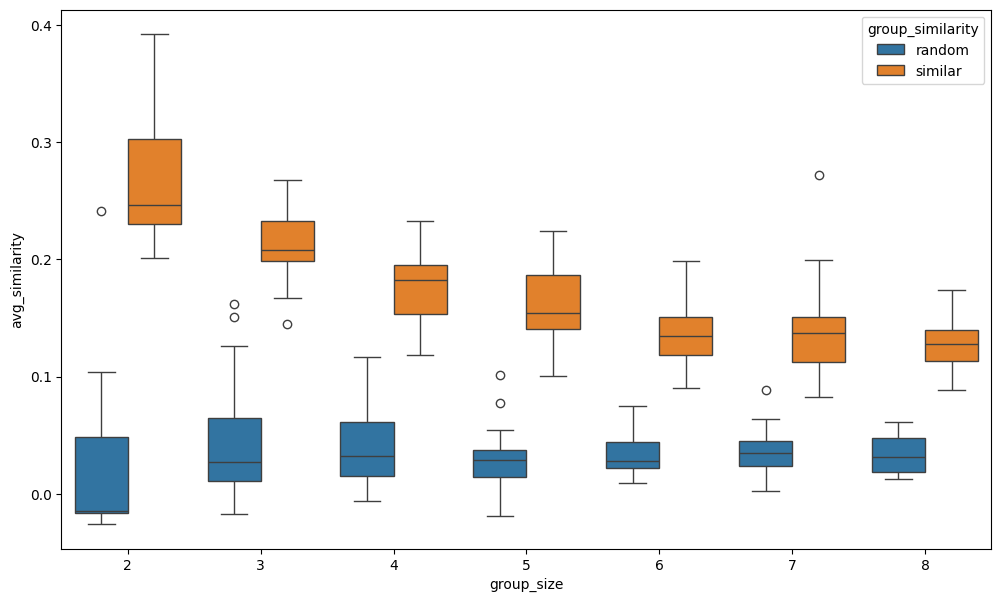

In [12]:
# Visualizing similarities for each type of group we created

import seaborn as sns


plt.rcParams["figure.figsize"] = (12,7)
sns.boxplot(x = groups_df['group_size'],
            y = groups_df['avg_similarity'],
            hue = groups_df['group_similarity'])
import matplotlib.pyplot as plt

#### 4. Train/Test split


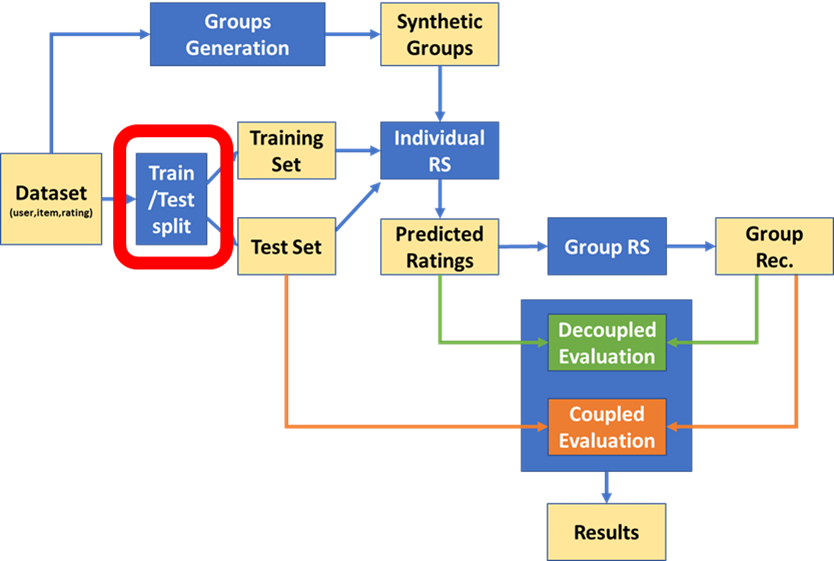

- Which strategy?
- Stratified split?
  
The choice of the criteria for splitting should be carefully defined on the basis of the problem we have, as well as the computational constraints. In this example, due to time constraints, we use a Hold-out (80-20 split) stratified by user. This ensures to have 80% of evaluations in the training set and 20% in the test set for each user. Different methodologies could be applied, and this choice needs to be properly motivated.

In [13]:
ratings_df =ratings_df.rename(columns={
    'RatingID': 'ratingId',  # Fixed typo
    'UserID': 'user',
    'WineID': 'item',
    'Vintage': 'vintage',
    'Rating': 'rating',
    'Date': 'date'
})

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

display(ratings_df.shape)
WineIDs = set(ratings_df["item"].tolist())
users = set(ratings_df["user"].tolist())



train_df, test_df = train_test_split(ratings_df, test_size=0.2, stratify=ratings_df[["user"]])



(132694, 4)

#### 5. Individual RS training and generating predicted ratings.

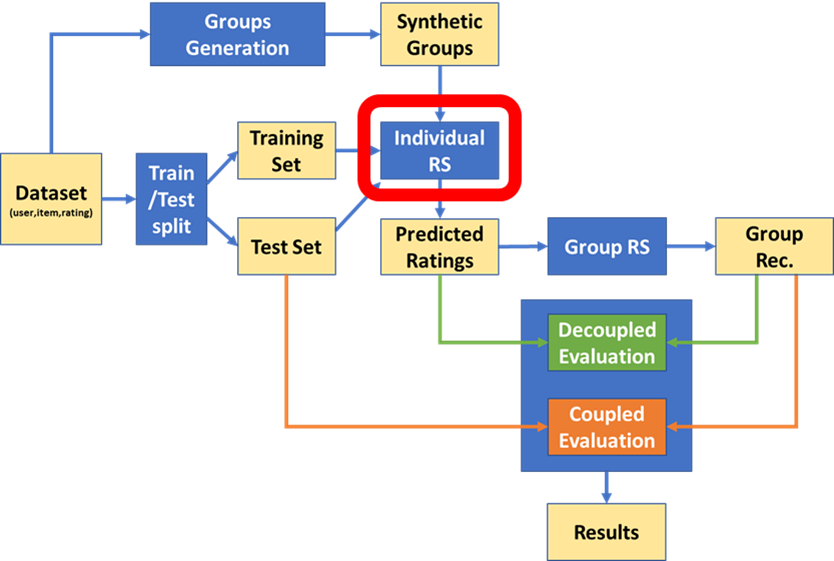

- Which strategy to use?
- Which WineIDs we consider for computing the predicted ratings?


In [15]:
train_df = train_df.rename(columns={
    'RatingID': 'ratingId',  # Fixed type
    'UserID': 'user',
    'WineID': 'item',
    'Vintage': 'vintage',
    'Rating': 'rating',
    'Date': 'date'
})


In [16]:
import Racommander as RC

recommender = RC.Recommender()
recommender.load_model("item-item")



INFO:root:Loading model: item-item
INFO:root:Model item-item loaded successfully.


In [17]:
# Generate predicted ratings

# test_df['predicted_rating'] = recsys.predict(test_df)
test_WineID = set(test_df["item"].tolist())
test_user = set(test_df["user"].tolist())
test_rating=set(test_df["rating"].tolist())

display(len(test_WineID))
display(len(test_user))
display(len(test_rating))
display(test_rating)

835

8333

9

{1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0}

In [18]:
extended_test_df = pd.DataFrame({'item': list(test_WineID)}).merge(pd.DataFrame({'user': list(test_user)}), how='cross')
display(extended_test_df)

,item,user
0,112641,1245188
1,112641,1245200
2,112641,1212437
3,112641,1212442
4,112641,1212444
...,...,...
6958050,155647,1179634
6958051,155647,1179637
6958052,155647,1703926
6958053,155647,1048570


In [19]:
extended_test_df['rating'] = recommender.predict(extended_test_df)

display(extended_test_df)

# Count the number of NaN (null) values in the 'rating' column
null_ratings_count = extended_test_df['rating'].isnull().sum()

# Display the result
print(f'Number of null ratings: {null_ratings_count}')

,item,user,rating
0,112641,1245188,3.683231
1,112641,1245200,3.151618
2,112641,1212437,3.714943
3,112641,1212442,3.137912
4,112641,1212444,3.407169
...,...,...,...
6958050,155647,1179634,3.269884
6958051,155647,1179637,3.028285
6958052,155647,1703926,2.917476
6958053,155647,1048570,3.359207


Number of null ratings: 712068


In [20]:
from sklearn.decomposition import TruncatedSVD

# Convert the ratings dataframe to a pivot table (user-item matrix)
user_item_matrix = ratings_df.pivot(index='user', columns='item', values='rating').fillna(0)

# Apply SVD to the matrix
svd = TruncatedSVD(n_components=50)  # Choose appropriate number of latent factors
user_factors = svd.fit_transform(user_item_matrix)
item_factors = svd.components_

# Use these factors to predict missing ratings
predicted_ratings = np.dot(user_factors, item_factors)

# Convert the predicted ratings matrix back into a DataFrame
extended_test_df = pd.DataFrame(predicted_ratings, index=user_item_matrix.index,  # Use original UserID as index
                                    columns=user_item_matrix.columns)  # Use original WineID as columns

# Display the DataFrame
display(extended_test_df.shape)

# Convert the wide-format DataFrame back to a long-format DataFrame
predicted_ratings_long_df = extended_test_df.reset_index().melt(id_vars='user', var_name='item', value_name='rating')

# Sort the long-format DataFrame by 'PredictedRating' in descending order
extended_test_df = predicted_ratings_long_df.sort_values(by='rating', ascending=False)

# Display the top rows of the sorted DataFrame
display(extended_test_df.head())






(8333, 851)

,user,item,rating
5760769,1149212,179061,6.282112
5301516,1095942,174184,6.203085
5759678,1083712,179061,6.142942
1295343,1194997,111415,6.142192
5761526,1184213,179061,6.137194


#### 6. Aggregation strategies: generating group recommendations

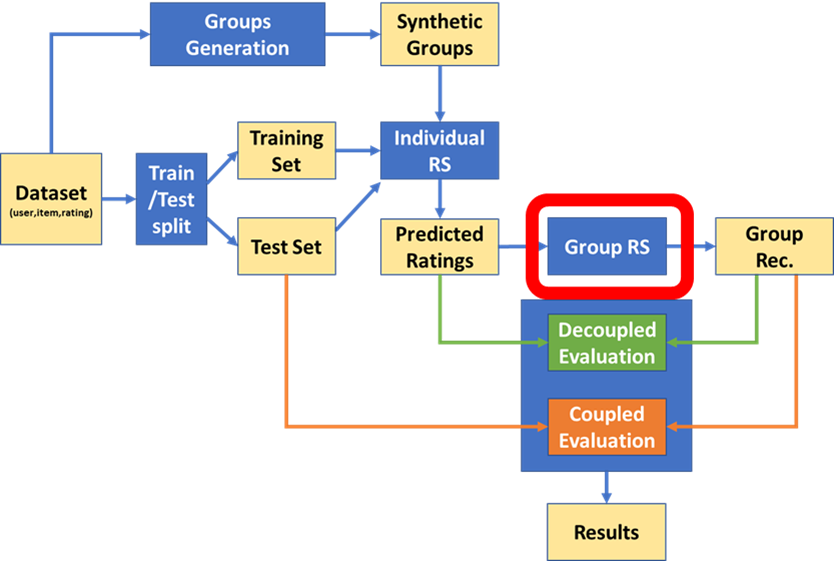


- Which strategies we want to evaluate?

In [21]:
import aggregators as aggr_utils
reload(aggr_utils)
import aggregators as aggr_utils

aggregation_strategies = ["BASE"]
recommendations_number = 10

def generate_group_recommendations_forall_groups(test_df, group_dict, recommendations_number):
    group_recommendations = dict()
    for group_id in group_dict:
        
#         print(datetime.now(), group_id)
        
        # extract group info
        group = group_dict[group_id]
        group_size = group['group_size']
        group_similarity = group['group_similarity']
        group_members = group['group_members']
            
        group_ratings = test_df.loc[test_df['user'].isin(group_members)]
        
        group_rec = dict()
        for aggregation_strategy in aggregation_strategies:
            agg = aggr_utils.AggregationStrategy.getAggregator(aggregation_strategy)
            group_rec = {**group_rec, **agg.generate_group_recommendations_for_group(group_ratings, recommendations_number)}
        
        
        group_recommendations[group_id] = group_rec
        
    return group_recommendations

In [22]:
group_recommendations = generate_group_recommendations_forall_groups(extended_test_df, group_dict, recommendations_number)

display(group_recommendations)

{0: {'ADD': [179012,
   111468,
   111431,
   135860,
   111478,
   155334,
   111458,
   111448,
   193483,
   111434],
  'MUL': [111468,
   155334,
   179012,
   111434,
   111458,
   155368,
   111431,
   111495,
   155353,
   155438],
  'LMS': [111434,
   155438,
   155368,
   155334,
   111495,
   111558,
   111468,
   155353,
   111667,
   111458],
  'MPL': [179012,
   111468,
   135860,
   111431,
   111478,
   155334,
   111448,
   111458,
   193483,
   167419]},
 1: {'ADD': [162506,
   167445,
   111478,
   170982,
   101563,
   155308,
   179039,
   179084,
   101660,
   179069],
  'MUL': [167445,
   162506,
   179084,
   179039,
   101660,
   179027,
   101610,
   111471,
   179053,
   179069],
  'LMS': [179084,
   179027,
   101660,
   101610,
   179053,
   101566,
   111471,
   106536,
   101584,
   167445],
  'MPL': [162506,
   111478,
   170982,
   155308,
   167445,
   101563,
   179039,
   101617,
   179069,
   111471]},
 2: {'ADD': [101563,
   155308,
   135860,
   10

In [23]:
# Visualize the group recommendation
group_recommender_full_dataframe=group_recommendations
wine_df.reset_index(inplace=True)

wine_df= pd.DataFrame(wine_df)
recommendations_df = pd.DataFrame([
    {'strategy': strategy, 'wine_id': wine_id}
    for strategy, wine_ids in group_recommendations.items()
    for wine_id in wine_ids
])
recommendations_list = []
for group_id, strategies in group_recommendations.items():
    for strategy, wine_ids in strategies.items():
        for wine_id in wine_ids:
            recommendations_list.append({'group_id': group_id, 'strategy': strategy, 'wine_id': wine_id})

recommendations_df = pd.DataFrame(recommendations_list)

print(wine_df.columns)
recommendations_df['wine_id'] = recommendations_df['wine_id'].astype(str)
wine_df['WineID'] = wine_df['WineID'].astype(str)  # 确保 WineID 列也是字符串类型
merged_df = recommendations_df.merge(wine_df, left_on='wine_id', right_on='WineID', how='left')
# print("Merged DataFrame:")
# print(merged_df)

# print(merged_df.head(2))

for group_id in merged_df['group_id'].unique():
    group_df = merged_df[merged_df['group_id'] == group_id][['group_id', 'strategy', 'wine_id', 'WineName']]
    print(f"DataFrame for group '{group_id}':")
    print(group_df)
    print("\n")



Index(['WineID', 'WineName', 'Type', 'Elaborate', 'Grapes', 'Harmonize', 'ABV',
       'Body', 'Acidity', 'Code', 'Country', 'RegionID', 'RegionName',
       'WineryID', 'WineryName', 'Website', 'Vintages'],
      dtype='object')
DataFrame for group '0':
    group_id strategy wine_id  \
0          0      ADD  179012   
1          0      ADD  111468   
2          0      ADD  111431   
3          0      ADD  135860   
4          0      ADD  111478   
5          0      ADD  155334   
6          0      ADD  111458   
7          0      ADD  111448   
8          0      ADD  193483   
9          0      ADD  111434   
10         0      MUL  111468   
11         0      MUL  155334   
12         0      MUL  179012   
13         0      MUL  111434   
14         0      MUL  111458   
15         0      MUL  155368   
16         0      MUL  111431   
17         0      MUL  111495   
18         0      MUL  155353   
19         0      MUL  155438   
20         0      LMS  111434   
21         0      L

#### 7. Evaluation

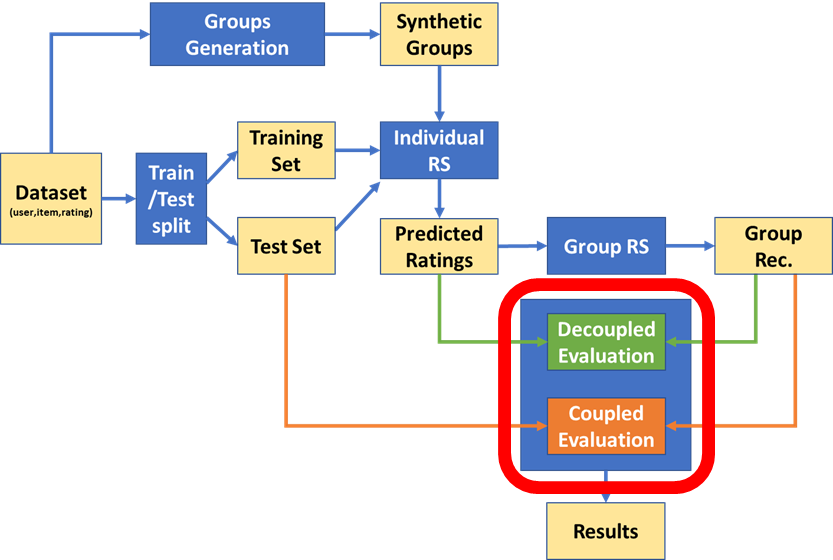

- Coupled or Decoupled?
- Metric? How we aggregate metrics for group members?

#### 7.1 NDCG metric

- We see an implementation of the NDCG metric.


In [24]:
def evaluateUserNDCG(user_ground_truth, group_recommendation):
    dcg = 0

    for k, item in enumerate(group_recommendation):
        dcg = dcg + ((user_ground_truth.loc[item, "final_rating"] if item in user_ground_truth.index else 0) / np.log2(k + 2)) # +2? CHeck with the course slides

    idcg = 0
    user_ground_truth.sort_values("final_rating", inplace=True, ascending=False)
    for k in range(min(len(user_ground_truth), len(group_recommendation))):
        idcg = idcg + (user_ground_truth.iloc[k]["final_rating"] / np.log2(k + 2)) # +2? CHeck with the course slides
    if idcg > 0:
        ndcg = dcg / idcg
    else:
        ndcg = 0

    return ndcg


#### 7.2 Aggregating metric for group members

- We report results aggregating using: mean, min, minmax.

In [25]:
def evaluateGroupRecommendation(group_ground_truth, group_recommendation, group_members):
    ndcg_list = list()
    dcg_list = list()
    binarize_feedback=False
    binarize_feedback_positive_threshold=10
    for user in group_members:
        
        user_ground_truth = group_ground_truth.loc[group_ground_truth['user'] == user]
        user_ground_truth.set_index("item", inplace=True)

        # feedback binarization
        if binarize_feedback == True:
            user_ground_truth["final_rating"] = 0
            user_ground_truth.loc[user_ground_truth.rating >= binarize_feedback_positive_threshold,"final_rating"] = 1         
        # no modifications to feedback
        else:
            user_ground_truth["final_rating"] = user_ground_truth["rating"]
        
        ndcg_user = evaluateUserNDCG(user_ground_truth, group_recommendation)
        ndcg_list.append(ndcg_user)

        # failsafe for all negative results
        if np.amax(ndcg_list) > 0:
            ndcg_min_max = np.amin(ndcg_list) / np.amax(ndcg_list)
        else:
            ndcg_min_max = 0.0
            dcg_min_max = 0.0
    return [
        {
            "metric": "NDCG",
            "aggr_metric": "mean",
            "value": np.mean(ndcg_list)
        },
        {
            "metric": "NDCG",
            "aggr_metric": "min",
            "value": np.amin(ndcg_list)
        },
        {
            "metric": "NDCG",
            "aggr_metric": "minmax",
            "value": ndcg_min_max
        }
    ]



#### 7.3 Evaluating recommendations for all the groups

In [26]:
def evaluate_group_recommendations_forall_groups(ground_truth, group_recommendations, group_dict):
                                                 
    group_evaluations = list()
    for group_id in group_dict:
        
        
        # extract group info
        group = group_dict[group_id]
        group_size = group['group_size']
        group_similarity = group['group_similarity']
        group_members = group['group_members']
        group_rec = group_recommendations[group_id]
            
        # filter ratings in ground_truth for the group members
        group_ground_truth = ground_truth.loc[ground_truth['user'].isin(group_members)]
        

        for aggregation_strategy in group_rec:
            agg_group_rec = group_rec[aggregation_strategy]
            agg_group_rec_eval = evaluateGroupRecommendation(group_ground_truth, agg_group_rec, group_members)
    
            # Adding aggregation strategy info
            for row in agg_group_rec_eval:
                row['aggregation_strategy'] = aggregation_strategy
                row['group_id'] = group_id

            group_evaluations = group_evaluations + agg_group_rec_eval
        
    return group_evaluations    

In [27]:
print(extended_test_df.columns)


Index(['user', 'item', 'rating'], dtype='object')


In [28]:

test_df=test_df.drop(columns=['rating'])
display(test_df.head(5))
print(test_df.columns)

,ratingId,user,item
24859,2321915,1196586,111457
104171,14465442,1630026,141829
97751,13428655,1289833,170984
87161,11733384,1142693,101635
45948,5584805,1243399,111624


Index(['ratingId', 'user', 'item'], dtype='object')


In [29]:
# Reorder columns by specifying the desired order
train_df = train_df[['item', 'user', 'rating']]

# Verify the new column order
print(train_df.columns)


Index(['item', 'user', 'rating'], dtype='object')


#### 7.4 Decoupled Evaluation

- In this case the ground truth are the predicted ratings

In [30]:
import warnings
warnings.filterwarnings('ignore')

ground_truth = extended_test_df
print(ground_truth)
decoupled_results = evaluate_group_recommendations_forall_groups(ground_truth, group_recommendations, group_dict)
display(decoupled_results)


            user    item    rating
5760769  1149212  179061  6.282112
5301516  1095942  174184  6.203085
5759678  1083712  179061  6.142942
1295343  1194997  111415  6.142192
5761526  1184213  179061  6.137194
...          ...     ...       ...
4692172  1019016  167425 -2.062762
1359098  1026308  111434 -2.089674
3767195  1016381  155339 -2.090371
1478248  1180773  111484 -2.114093
4696368  1223802  167425 -2.276151

[7091383 rows x 3 columns]


[{'metric': 'NDCG',
  'aggr_metric': 'mean',
  'value': 0.709475883373592,
  'aggregation_strategy': 'ADD',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'min',
  'value': 0.6026749904824226,
  'aggregation_strategy': 'ADD',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'minmax',
  'value': 0.7383218633760853,
  'aggregation_strategy': 'ADD',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'mean',
  'value': 0.5766910138820864,
  'aggregation_strategy': 'MUL',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'min',
  'value': 0.3180956711119861,
  'aggregation_strategy': 'MUL',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'minmax',
  'value': 0.3808222995367816,
  'aggregation_strategy': 'MUL',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'mean',
  'value': 0.4122421627857922,
  'aggregation_strategy': 'LMS',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'min',
  'value': 0.3500476291110988,
  'aggregation_strategy': 'LMS',
  

In [31]:
ground_truth['rating'] = recommender.predict(ground_truth)
display(ground_truth.head(3))
coupled_results = evaluate_group_recommendations_forall_groups(ground_truth, group_recommendations, group_dict)
display(coupled_results)


,user,item,rating
5760769,1149212,179061,4.938650
5301516,1095942,174184,5.045616
5759678,1083712,179061,4.593062


[{'metric': 'NDCG',
  'aggr_metric': 'mean',
  'value': 0.8493453504000594,
  'aggregation_strategy': 'ADD',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'min',
  'value': 0.8109401731683648,
  'aggregation_strategy': 'ADD',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'minmax',
  'value': 0.9134775456925991,
  'aggregation_strategy': 'ADD',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'mean',
  'value': 0.8354202071962739,
  'aggregation_strategy': 'MUL',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'min',
  'value': 0.7996888577167708,
  'aggregation_strategy': 'MUL',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'minmax',
  'value': 0.9179675471950021,
  'aggregation_strategy': 'MUL',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'mean',
  'value': 0.8320227207154633,
  'aggregation_strategy': 'LMS',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'min',
  'value': 0.801497401620868,
  'aggregation_strategy': 'LMS',
  

In [53]:
# 1913657, 1157893
user_ids = [1211238,
  1126323,
  1153158,
  1234112,
  1224634,
  1214006,
  1189309]
# Initialize an empty list to store the top recommendations for all users
all_top_recommendations = []

# Loop through each user and get the top 10 recommended items
for user_id in user_ids:
    user_ratings = extended_test_df[extended_test_df['user'] == user_id]
    top_items = user_ratings.sort_values(by='rating', ascending=False)
    
    # Add user ID to each row in top_items
    top_items['user'] = user_id

    # Append top_items to the list
    all_top_recommendations.append(top_items[['user', 'item', 'rating']])

# Concatenate the list into a single DataFrame
final_recommendations_df = pd.concat(all_top_recommendations, ignore_index=True)

# Display the final DataFrame
display(final_recommendations_df.head(20))


,user,item,rating
0,1211238,112664,5.128884
1,1211238,174184,4.966163
2,1211238,179061,4.855225
3,1211238,181280,4.833658
4,1211238,111395,4.830595
5,1211238,112084,4.814918
6,1211238,111415,4.744012
7,1211238,105969,4.743550
8,1211238,179043,4.731435
9,1211238,195170,4.724154


In [ ]:
   179012,
   111468,
   111431,
   135860,
   111478,
   155334,
   111458,
   111448,
   193483,
   111434

In [52]:
def approvalVoting(data):
    df=pd.DataFrame(data)
    # Approval Voting
    theta=4
    larger_df=df[df['rating']>=theta]
    counts=larger_df['item'].value_counts()
    # transform into DataFrame
    vote_counts=counts.reset_index()
    vote_counts.columns=['item','vote_count_in_total']
    majority_based_recommendation=vote_counts.sort_values(by='vote_count_in_total',ascending=False)
    return majority_based_recommendation

def leastMesery(data):
    df=pd.DataFrame(data)
    minimal_rating=df.groupby('item')['rating'].min()
    minimal_rating_df=minimal_rating.reset_index()
    minimal_rating_df.columns=['item','minimal_rating']
    least_misery_recommendation=minimal_rating_df.sort_values(by='minimal_rating',ascending=True)
    return least_misery_recommendation

def multiply_rating(ratings):
    score=1
    for rating in ratings:
        score=score*rating
    return score

def multiplicative(data):
    df=pd.DataFrame(data)
    grouped= df.groupby('item')['rating']
    final_score=grouped.apply(multiply_rating)
    # transform into DataFrame
    multiply_score=final_score.reset_index()
    multiply_score.columns=['item','final_score']
    multiply_recommendation=multiply_score.sort_values(by='final_score',ascending=False)  
    return multiply_recommendation

result_df_leat_measure=leastMesery(final_recommendations_df)
result_df_Aproval=approvalVoting(final_recommendations_df)
result_df_multi=multiplicative(final_recommendations_df)
display(result_df_leat_measure.head())
print("bwbdbw")
display(result_df_Aproval.head())
print
display(result_df_multi.head())

,item,minimal_rating
4,111415,4.572720
6,112664,4.594847
3,111395,4.597542
19,182169,4.606889
15,180330,4.620088


bwbdbw


,item,vote_count_in_total
0,174184,7
1,181280,6
2,111415,5
3,180330,5
4,182169,4


,item,final_score
10,174184,68437.253219
17,181280,13431.734834
15,180330,2655.389606
4,111415,2424.841638
22,183379,616.422416


In [54]:
def approvalVoting(data):
    df=pd.DataFrame(data)
    # Approval Voting
    theta=4
    larger_df=df[df['rating']>=theta]
    counts=larger_df['item'].value_counts()
    # transform into DataFrame
    vote_counts=counts.reset_index()
    vote_counts.columns=['item','vote_count_in_total']
    majority_based_recommendation=vote_counts.sort_values(by='vote_count_in_total',ascending=False)
    return majority_based_recommendation

def leastMesery(data):
    df=pd.DataFrame(data)
    minimal_rating=df.groupby('item')['rating'].min()
    minimal_rating_df=minimal_rating.reset_index()
    minimal_rating_df.columns=['item','minimal_rating']
    least_misery_recommendation=minimal_rating_df.sort_values(by='minimal_rating',ascending=True)
    return least_misery_recommendation

def multiply_rating(ratings):
    score=1
    for rating in ratings:
        score=score*rating
    return score

def multiplicative(data):
    df=pd.DataFrame(data)
    grouped= df.groupby('item')['rating']
    final_score=grouped.apply(multiply_rating)
    # transform into DataFrame
    multiply_score=final_score.reset_index()
    multiply_score.columns=['item','final_score']
    multiply_recommendation=multiply_score.sort_values(by='final_score',ascending=False)  
    return multiply_recommendation

result_df_leat_measure=leastMesery(final_recommendations_df)
result_df_Aproval=approvalVoting(final_recommendations_df)
result_df_multi=multiplicative(final_recommendations_df)
display(result_df_leat_measure.head())
print("bwbdbw")
display(result_df_Aproval.head())
print
display(result_df_multi.head())

,item,minimal_rating
45,101008,1.614269
393,140410,1.874405
793,193719,2.027068
9,100016,2.075993
506,162894,2.090500


bwbdbw


,item,vote_count_in_total
0,112664,7
44,111422,7
50,111415,7
49,179043,7
48,162497,7


,item,final_score
636,174184,68437.253219
730,181280,61076.379623
224,112084,60110.351195
719,180330,56475.356576
691,179061,55023.218295
